In [3]:
import gdown
import glob
import folium
import pandas as pd
import os
import numpy as np
import datetime 
import seaborn as sns
import scipy.stats as stat
from matplotlib import pyplot as plt
from arcgis.gis import GIS
from pylab import *

import json
from geojson import Feature, FeatureCollection, Point

**Load Mean Temperature and Precipitation Data For Stations.**

In [5]:
temp_prec_filename = 'https://raw.githubusercontent.com/ielattar/Climate-Change/main/data/precipitation_temperature.csv'
temp_prec_df = pd.read_csv(temp_prec_filename,engine='python').reset_index()



**Replace -9999.9 with NA Then drop NA for temperature and precipitation fields.**

In [ ]:
temp_prec_df.drop(temp_prec_df.columns[[1]], axis=1, inplace=True)
temp_prec_df=temp_prec_df.replace(-9999.9, np.nan)
temp_prec_df=temp_prec_df.dropna(axis=0, subset=['mean-temp(celsius)','total-snow(mm)','total-prec(mm)','total-rain(mm)'])
temp_prec_df


**Fetch Top Two Stations with the greatest number of records for each Province.**

In [6]:
temp_prec_df_count=temp_prec_df.groupby(['Prov','station\'s name']).size().sort_values(ascending=False).reset_index(name='count') 
sample_stations_df=temp_prec_df_count.groupby('Prov').head(2)
sample_stations_df

,Prov,station's name,count
0,ON,WOODSTOCK,147
1,QC,BAGOTVILLE,138
2,ON,HALIBURTON,130
4,MB,NEEPAWA MURRAY 6 SOUTHWEST,128
5,BC,BARKERVILLE,128
6,BC,AGASSIZ,125
7,QC,BROME,125
8,AB,BANFF,124
9,SK,MOOSE JAW,123
10,SK,INDIAN HEAD,123



**Filter the records to only include records from Top Stations.**

In [4]:
names_list = sample_stations_df['station\'s name'].values.tolist() 
name_list_str=','.join(names_list)
print(name_list_str)
filtered_temp_prec_df = temp_prec_df[temp_prec_df['station\'s name'].isin(names_list)]


WOODSTOCK,AGASSIZ,BARKERVILLE,NEEPAWA MURRAY 6 SOUTHWEST,BANFF,OWEN SOUND MOE,INDIAN HEAD,BAGOTVILLE ,ST GEORGES,MORDEN,KELLIHER,LACOMBE,ST MARGARET'S BAY,REXTON,DEMING,GOOSE ,NEPISIGUIT FALLS,CHESTERFIELD INLET ,PELLY RANCH,IQALUIT,MOULD BAY,EXPLOITS DAM,INUVIK,SHINGLE POINT 



**Create a 2D scatterplot with an overlaid regression line For precipiation over time for Two Stations per Province.**

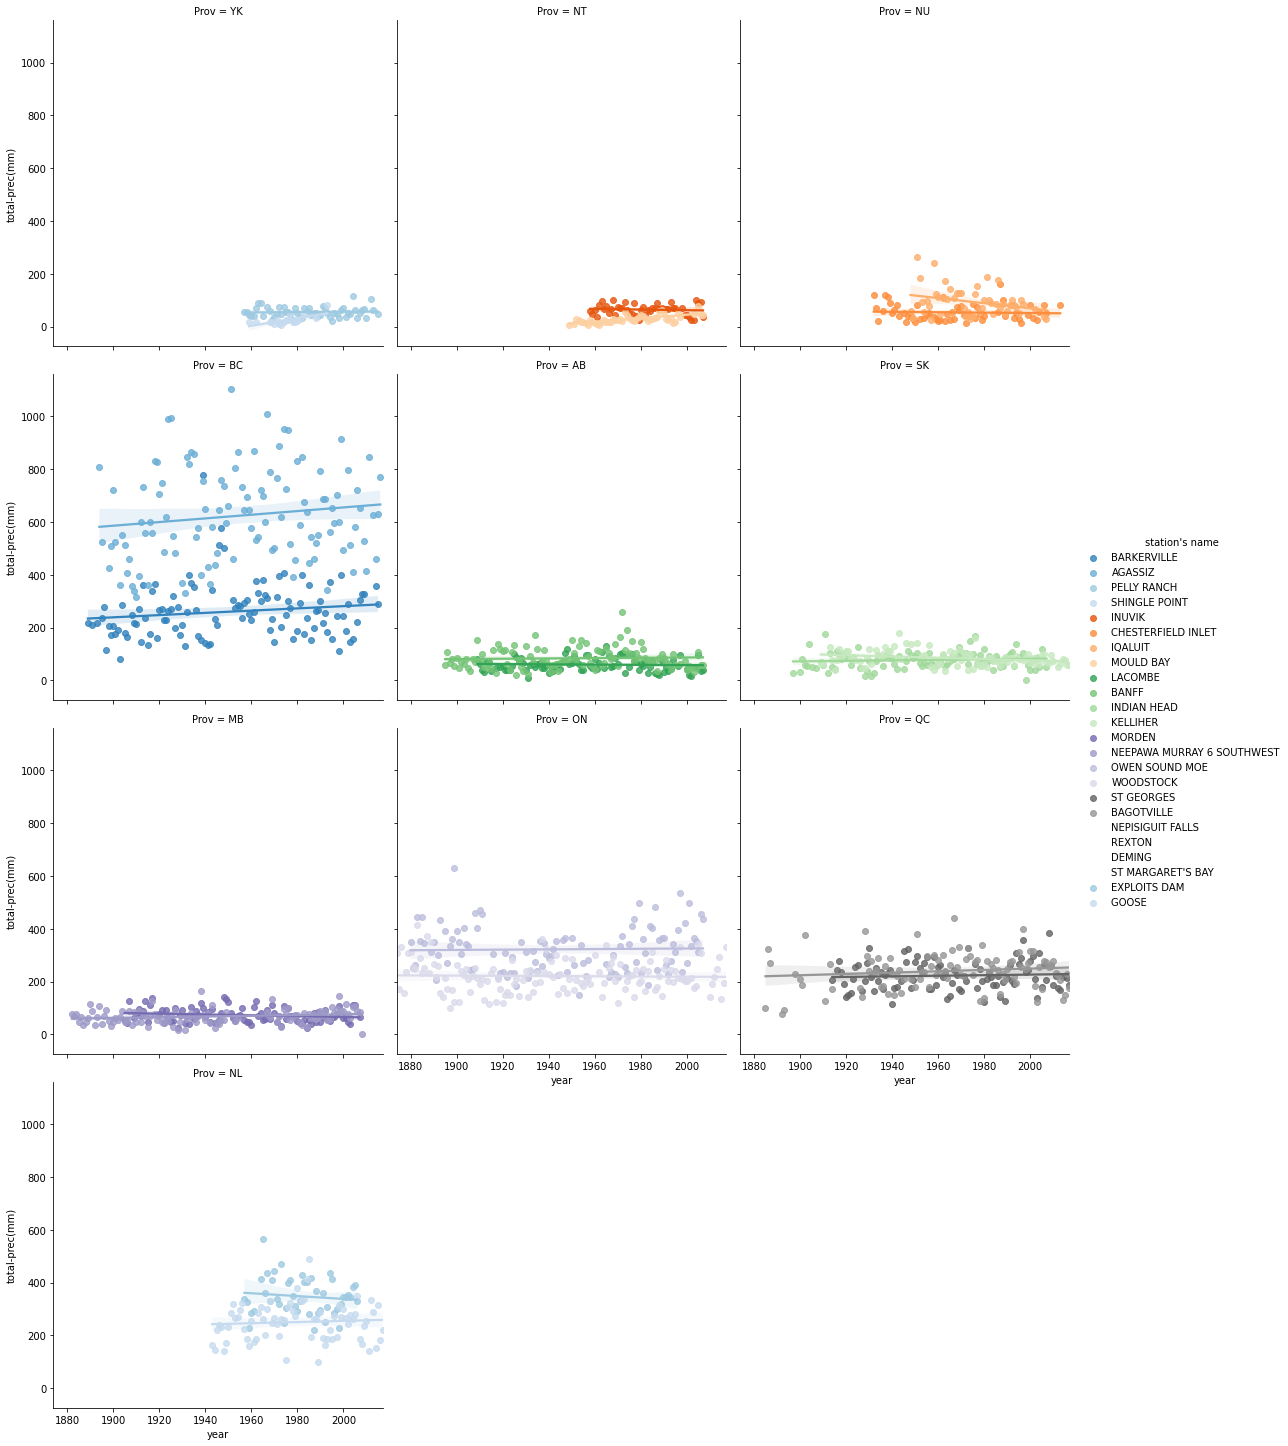

In [5]:
chart=sns.lmplot(
            x='year',
            y='total-prec(mm)',
            data= filtered_temp_prec_df,
            col='Prov',
            hue='station\'s name',
            legend_out=True,
            palette="tab20c",
            col_wrap=3,
            col_order=["YK","NT","NU","BC","AB","SK","MB","ON","QC","NL"]
        )



**Loop through the list of Provinces and generate a joint scatter\ distribution plot between temperature & precipitation.**

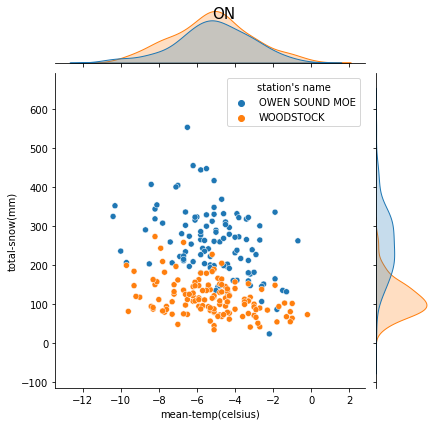

<Figure size 432x288 with 0 Axes>

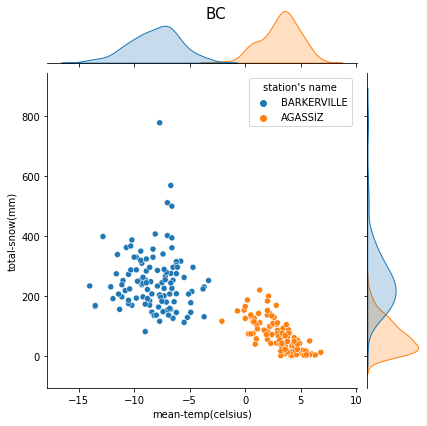

<Figure size 432x288 with 0 Axes>

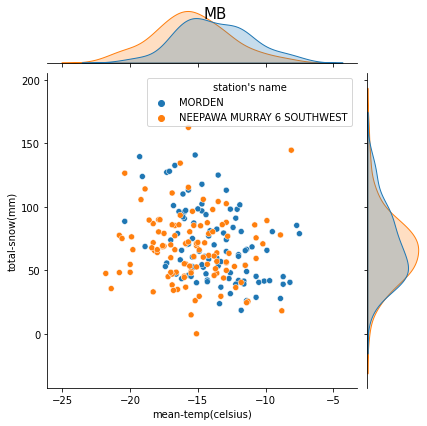

<Figure size 432x288 with 0 Axes>

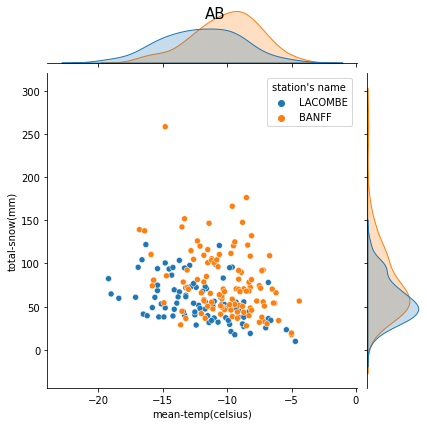

<Figure size 432x288 with 0 Axes>

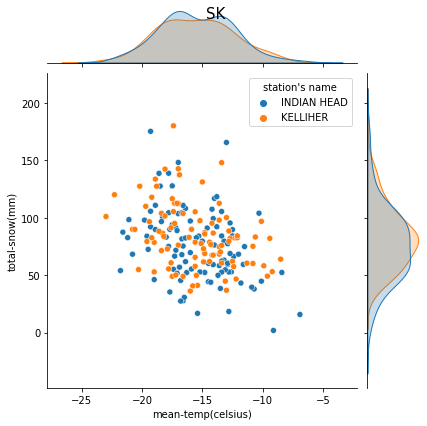

<Figure size 432x288 with 0 Axes>

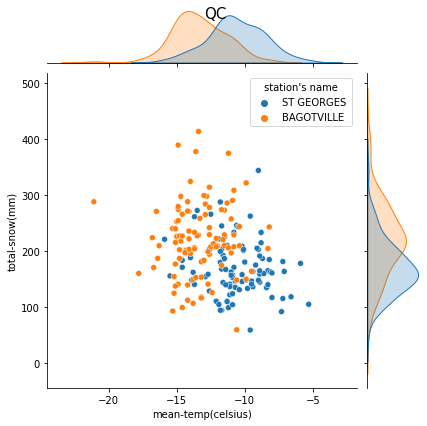

<Figure size 432x288 with 0 Axes>

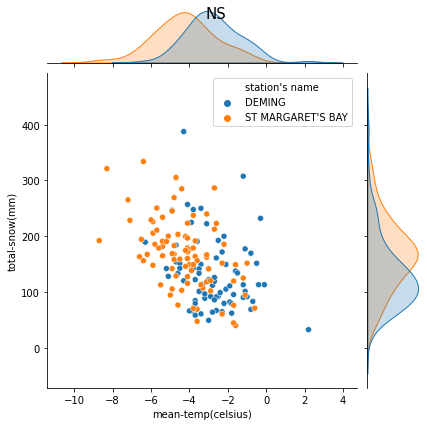

<Figure size 432x288 with 0 Axes>

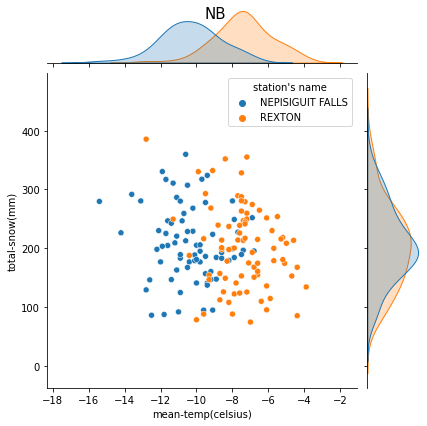

<Figure size 432x288 with 0 Axes>

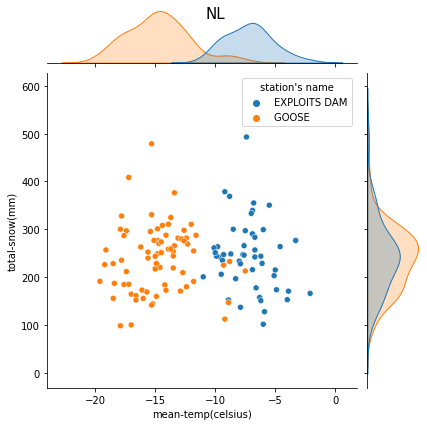

<Figure size 432x288 with 0 Axes>

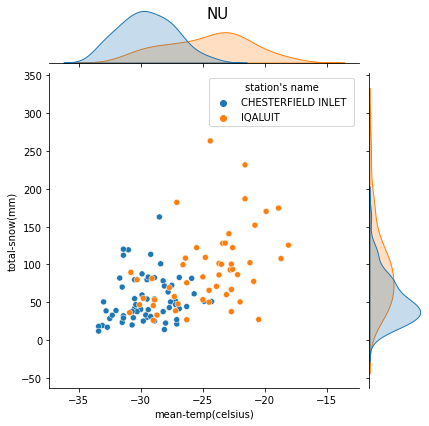

<Figure size 432x288 with 0 Axes>

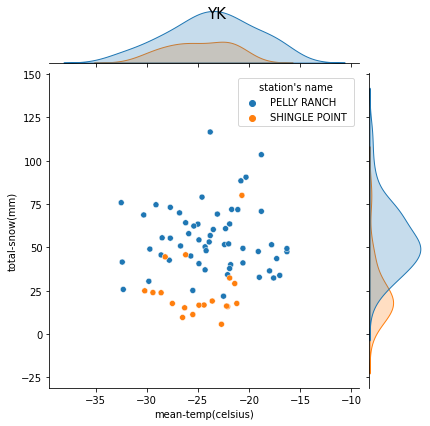

<Figure size 432x288 with 0 Axes>

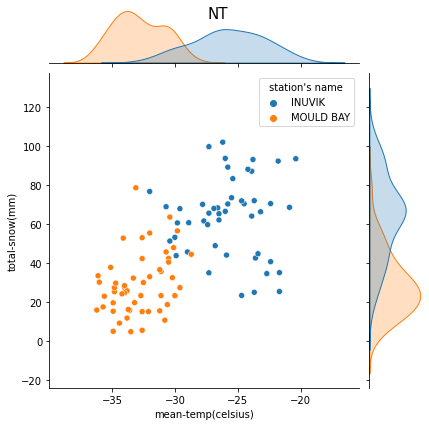

<Figure size 432x288 with 0 Axes>

In [21]:
provinces_list = sample_stations_df['Prov'].unique().tolist() 
for aProvince in provinces_list:
    queryString="Prov == '"+ aProvince + "'"
    jp=sns.jointplot(
            x="mean-temp(celsius)",
            y="total-snow(mm)",
            hue="station\'s name",
            data=filtered_temp_prec_df.query(queryString)
            )
    jp.fig.suptitle(aProvince,size=15)
    plt.show()
    plt.clf()


**Create a 2D scatterplot with an overlaid regression line For precipiation versus Temperature for Two Stations per Province.**

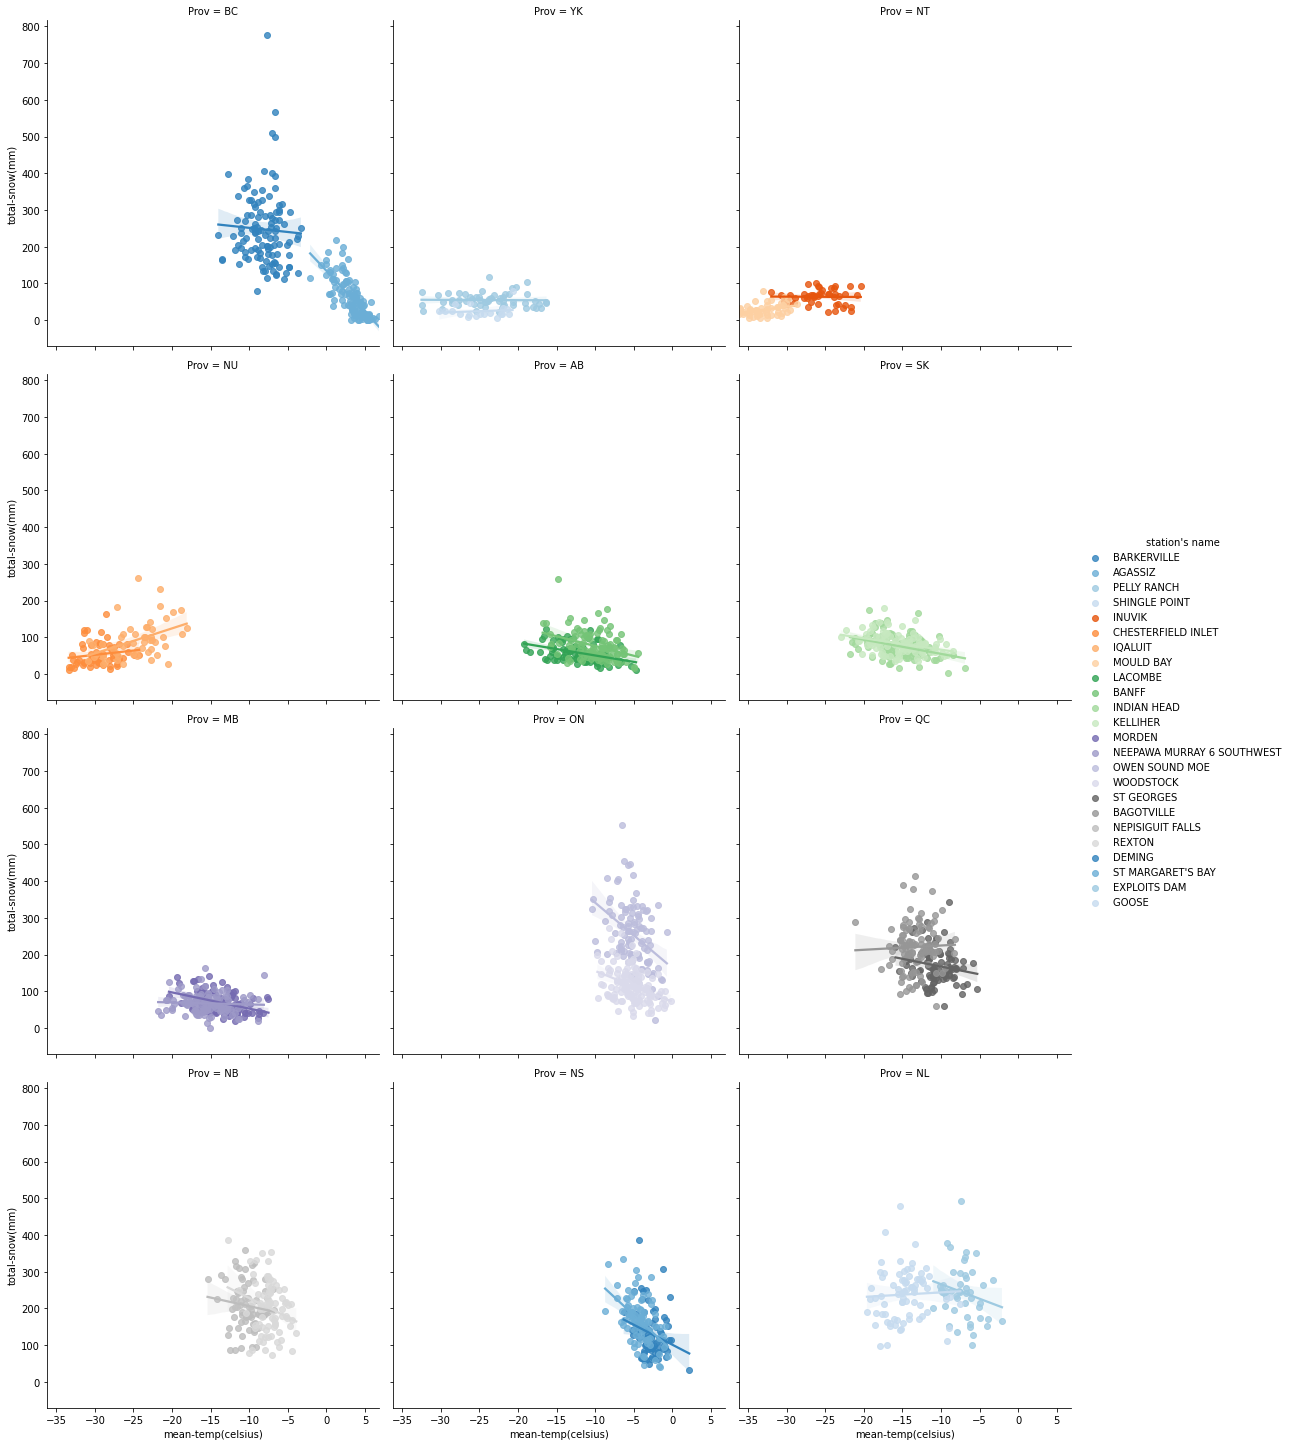

In [22]:
chart=sns.lmplot(
            x='mean-temp(celsius)',
            y='total-snow(mm)',
            data=filtered_temp_prec_df,
            col='Prov',
            hue='station\'s name',
            legend_out=True,
            palette="tab20c",
            col_wrap=3
        )
#chart.ax.legend(loc=3)
plt.show()

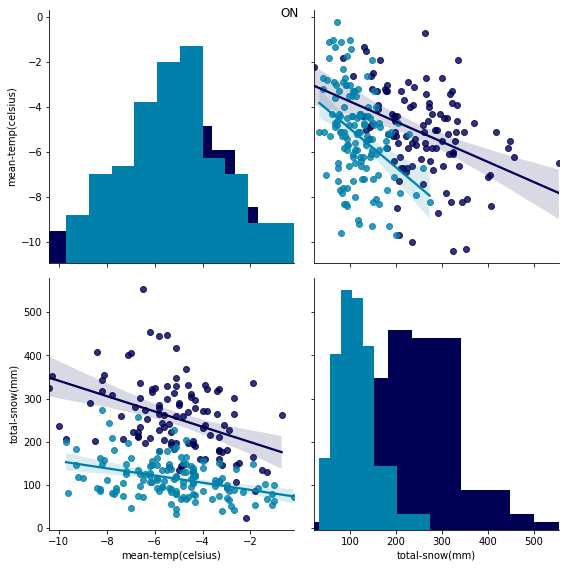

<Figure size 432x288 with 0 Axes>

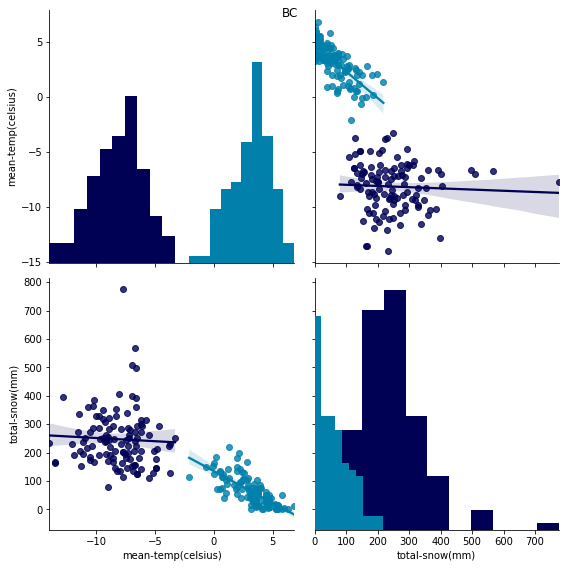

<Figure size 432x288 with 0 Axes>

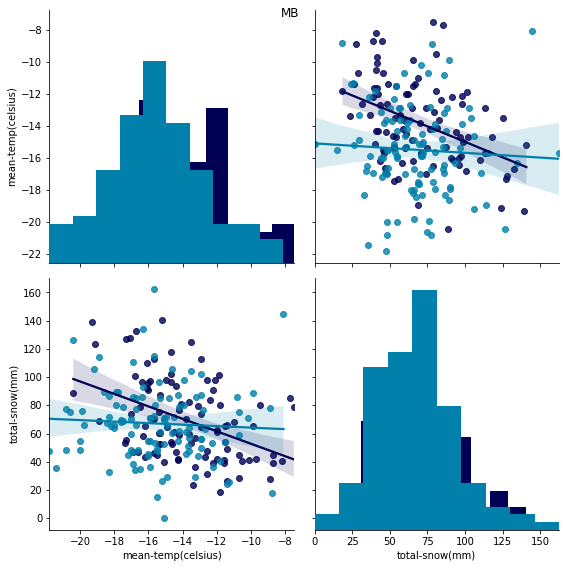

<Figure size 432x288 with 0 Axes>

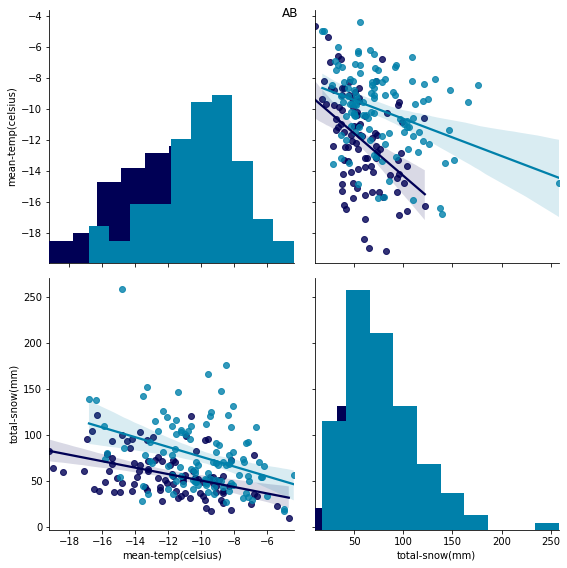

<Figure size 432x288 with 0 Axes>

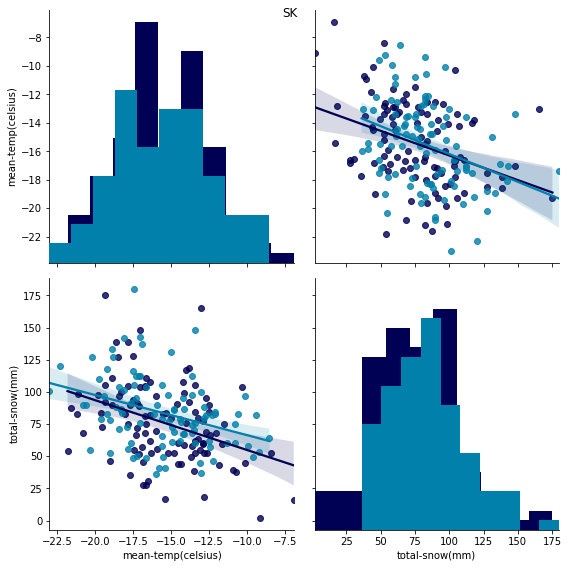

<Figure size 432x288 with 0 Axes>

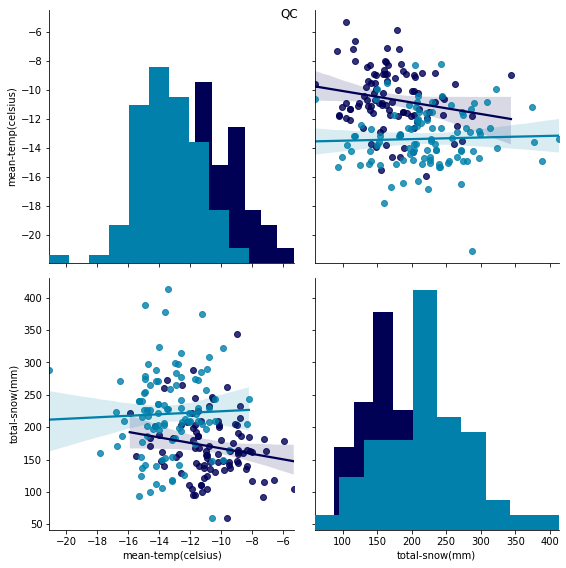

<Figure size 432x288 with 0 Axes>

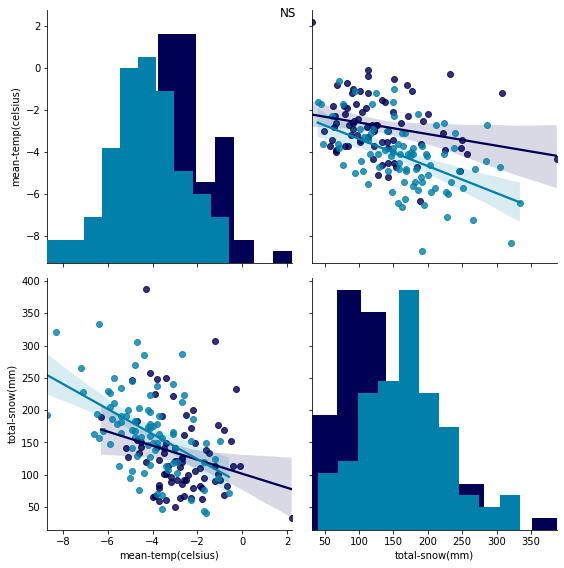

<Figure size 432x288 with 0 Axes>

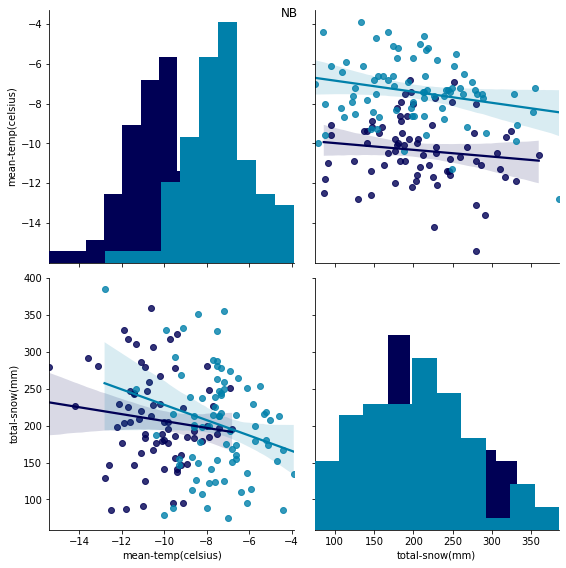

<Figure size 432x288 with 0 Axes>

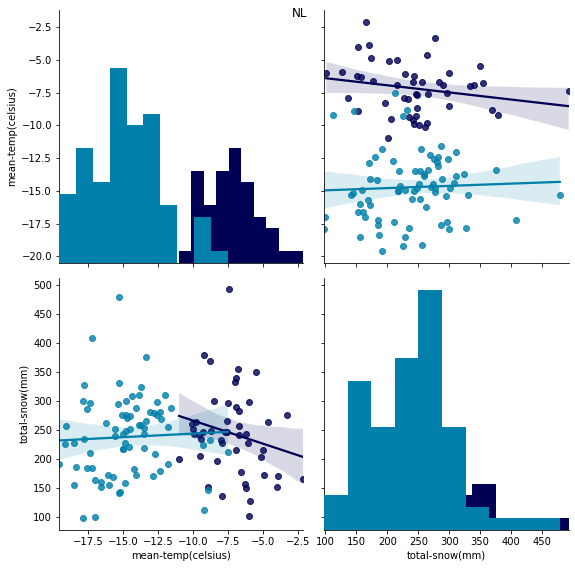

<Figure size 432x288 with 0 Axes>

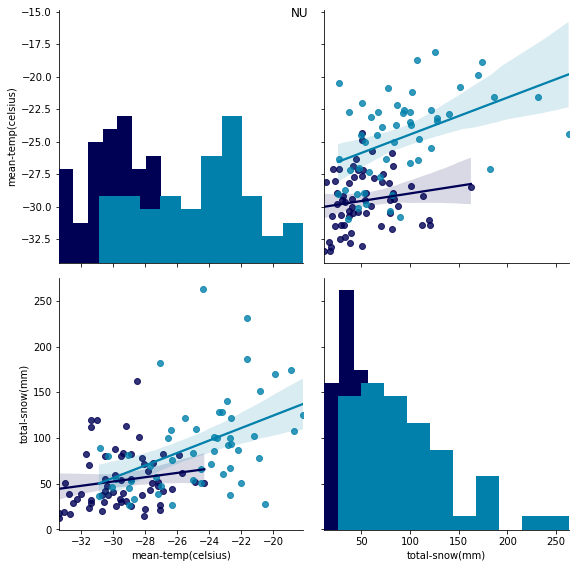

<Figure size 432x288 with 0 Axes>

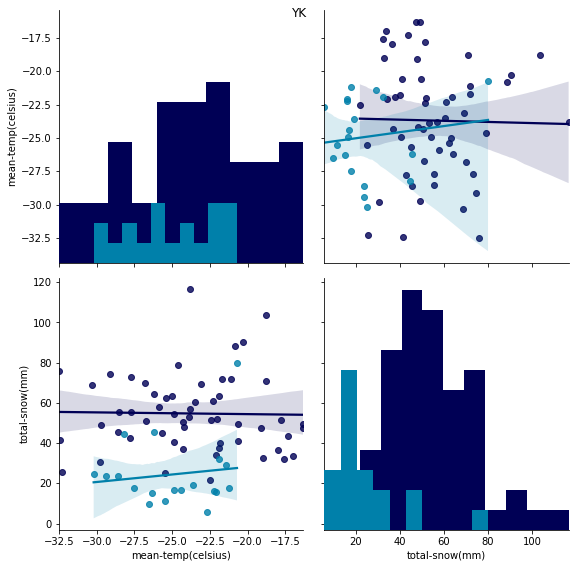

<Figure size 432x288 with 0 Axes>

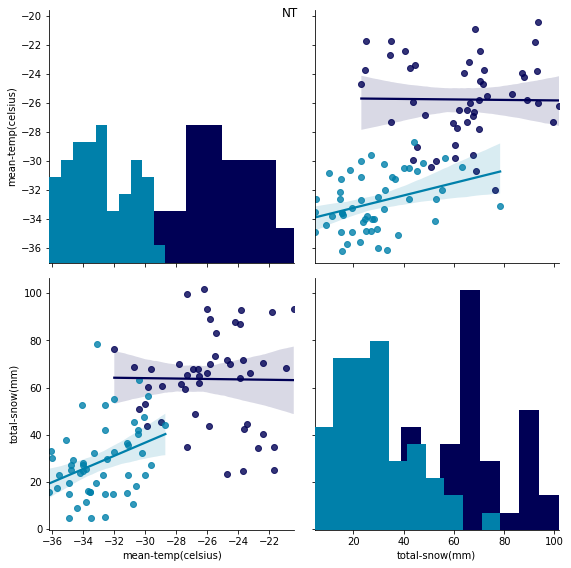

<Figure size 432x288 with 0 Axes>

In [34]:
provinces_list = sample_stations_df['Prov'].unique().tolist() 
for aProvince in provinces_list:
    queryString="Prov == '"+ aProvince + "'"
    g = sns.PairGrid(filtered_temp_prec_df.query(queryString) , vars=["mean-temp(celsius)", "total-snow(mm)" ], hue = 'station\'s name', height=4,palette="ocean")
    g.map_diag(plt.hist)
    g.map_offdiag(sns.regplot)
    g.fig.suptitle(aProvince)
    plt.show()
    plt.clf()






**Calculate Correlation Between Total Preciptitation and temperature for each Station and store it in a dataframe**

In [38]:
column_names = ["stnid","Prov" ,"mean_total_precipitation","correlation", "stn_name"]
correlation_prec_df = pd.DataFrame(columns = column_names)

stn_prov_df=temp_prec_df[['stnid','Prov','lat (deg)','station\'s name','long (deg)','elev (m)']].drop_duplicates()
stnid_list = temp_prec_df['stnid'].unique().tolist() 

for stnid in stnid_list:
    #lookup the station province
    stn_prov=stn_prov_df.loc[stn_prov_df['stnid'] == stnid, 'Prov'].iloc[0]
    stn_name=stn_prov_df.loc[stn_prov_df['stnid'] == stnid, 'station\'s name'].iloc[0]
    #fetch all the station records from the temp_prec_df
    station_records=temp_prec_df[temp_prec_df["stnid"] == stnid]
    #Calculate the mean.
    stn_mean_prec=station_records['total-prec(mm)'].mean()
    corr_mat=np.corrcoef(station_records['total-prec(mm)'],station_records['mean-temp(celsius)'])
    #Calculate the corrolation.
    new_row = {'stnid':stnid,'mean_total_precipitation':stn_mean_prec, 'correlation': corr_mat[0,1], 'Prov':stn_prov, 'stn_name':stn_name}
    correlation_prec_df  = correlation_prec_df.append(new_row, ignore_index=True)




**Create a Scatterplot to show relationship between correlation and temperature**

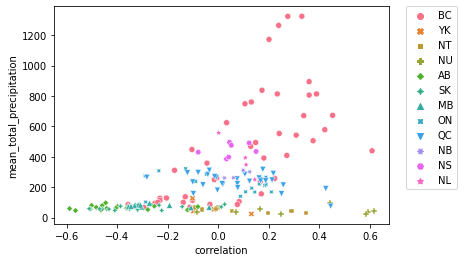

In [13]:
sns.scatterplot(data=correlation_prec_df, x="correlation", y="mean_total_precipitation" , hue="Prov", style="Prov" )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

**Join the correlation dataframe to station dataframe to append location fields.**

In [37]:
correlation_prec_df = correlation_prec_df.merge(stn_prov_df, how='inner', left_on=["stnid"], right_on=["stnid"])



**Plot the stations on ArcGIS Online Classified by Altitude and Correlation value (colo) **

In [39]:
gis = GIS()
webmap = gis.content.get('92e909bb9eaf4f10a40f47e1bc312815')


from arcgis.mapping import WebMap
weather_stations = WebMap(webmap)
weather_stations

from arcgis.widgets import MapView
mapview = MapView(gis=gis, item=weather_stations)
mapview.legend = True
mapview




MapView(layout=Layout(height='400px', width='100%'), legend=True)